This script compares ERA5 to CMIP6 models. Metrics evaluated are the timing of rain onset, the timing of wind onset, the total FW events, and the rain heatmap.

This script assumes all of these are already calculated and saved elsewhere, and will just load the data.

In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import cftime
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import scipy.stats as stats
from netCDF4 import Dataset
import h5py
import matplotlib.patches as patches
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
import matplotlib.colors
import datetime
import matplotlib.ticker as ticker
coords = xr.open_dataset('/Users/gt7/Desktop/Research/downscaled_data/coords/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Rain Onset Timing Bias

In [4]:
# custom colormap
segment_map3 = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])

# load era5
first_wet_era5 = xr.open_dataset('/era5/era5_1981_2010_first_wet.nc')
first_wet_era5 = first_wet_era5.__xarray_dataarray_variable__
era5_wet_mean = first_wet_era5.mean(dim='newyear')

# load models
model_pr_directory = '/model_directory/'
model_list_pr = [folder for folder in os.listdir(model_pr_directory) if os.path.isdir(os.path.join(model_pr_directory, folder)) and folder != ".DS_Store"]

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


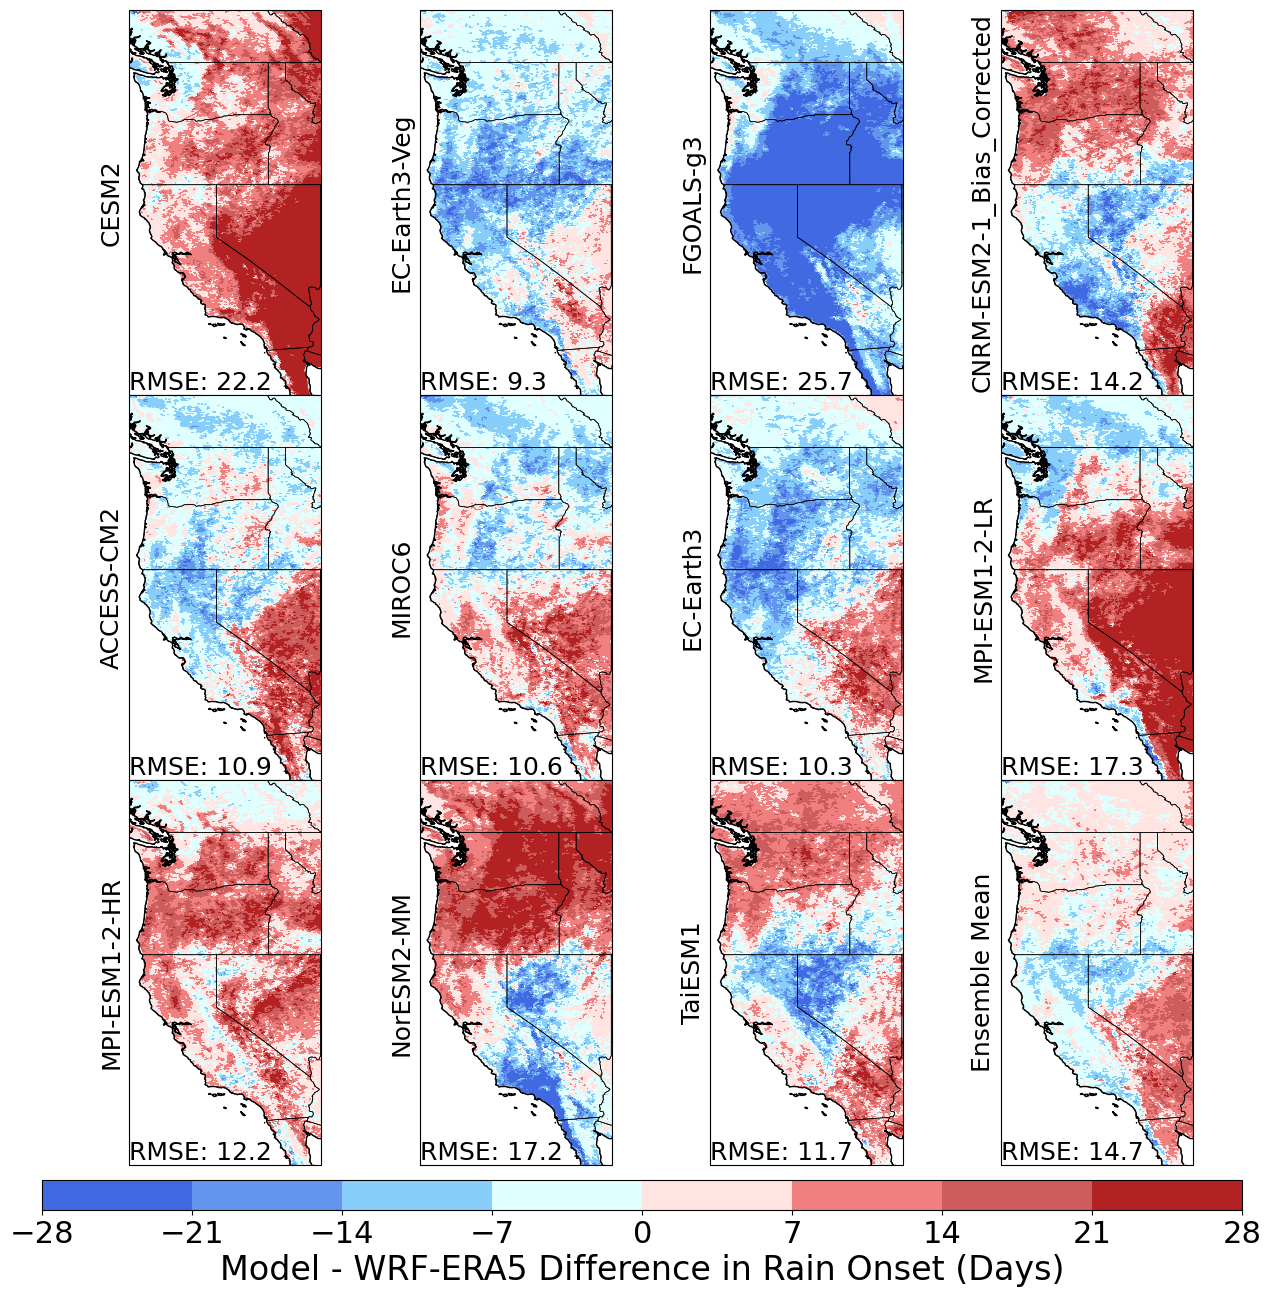

In [5]:
# calculate all of them and add them to an array, then add the ensemble mean to the array
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])


latmask = (lat_wrf > 30) & (lat_wrf < 52)
lonmask = (lon_wrf > -125) & (lon_wrf < -114)



fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
all_models = []
all_rmse = []
for model in model_list_pr:
    file = model_pr_directory+'/'+model+'/'+model+'_1981_2010_first_wet_and_wind_dry_spell.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wet_hist  

    first_wet_mean = first_wet_hist.mean(dim='newyear')
    bias = first_wet_mean - era5_wet_mean
    subset_bias = bias.where(latmask & lonmask, drop=True)
    squared_diff = (subset_bias)**2
    mse = squared_diff.mean(dim=('lat2d', 'lon2d'))
    rmse = np.sqrt(mse)
    all_models.append(bias)
    all_rmse.append(rmse)
all_models = xr.concat(all_models,dim='model')
all_rmse = xr.concat(all_rmse,dim='model')
ensemble_mean = all_models.mean(dim='model')
ensemble_mean_rmse = all_rmse.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
all_models_rmse = xr.concat([all_rmse,ensemble_mean_rmse],dim='model')
model_list_pr.append('Ensemble Mean')

for x, model in enumerate(model_list_pr):
    first_wet_mean = all_models_new[x]
    rmse = all_models_rmse[x]
    
    ax = plt.subplot(3, 4, x + 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(coords['lon2d'], coords['lat2d'], first_wet_mean, cmap=segment_map3, vmin=-28, vmax=28)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30, 52)
    ax.set_xlim(-125, -114)
    
    label = model + ' - ' + str(rmse.values.round(decimals=1, out=None))
    ax.set_ylabel(model, fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Add RMSE value in the upper left corner
    ax.text(-125, 30, f'RMSE: {rmse.values.round(decimals=1)}', fontsize=18, color='black', ha='left', va='bottom')


    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = plt.colorbar(im,ticks=[-28, -21, -14, -7, 0, 7, 14, 21, 28],cax=cbar_ax,orientation='horizontal')
#cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Model - WRF-ERA5 Difference in Rain Onset (Days)',fontsize=24)
#tick_spacing = 30
#cbar.locator = MultipleLocator(base=tick_spacing)
#cbar.update_ticks()
plt.show()

## Wind Onset Timing Bias

In [8]:
# load era5 wind
first_wind_era5 = xr.open_dataset('/era5/era5_1981_2010_first_wind.nc')
first_wind_era5 = first_wind_era5.wspd10mean
era5_wind_mean = first_wind_era5.mean(dim='newyear')

# load models
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_pr_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


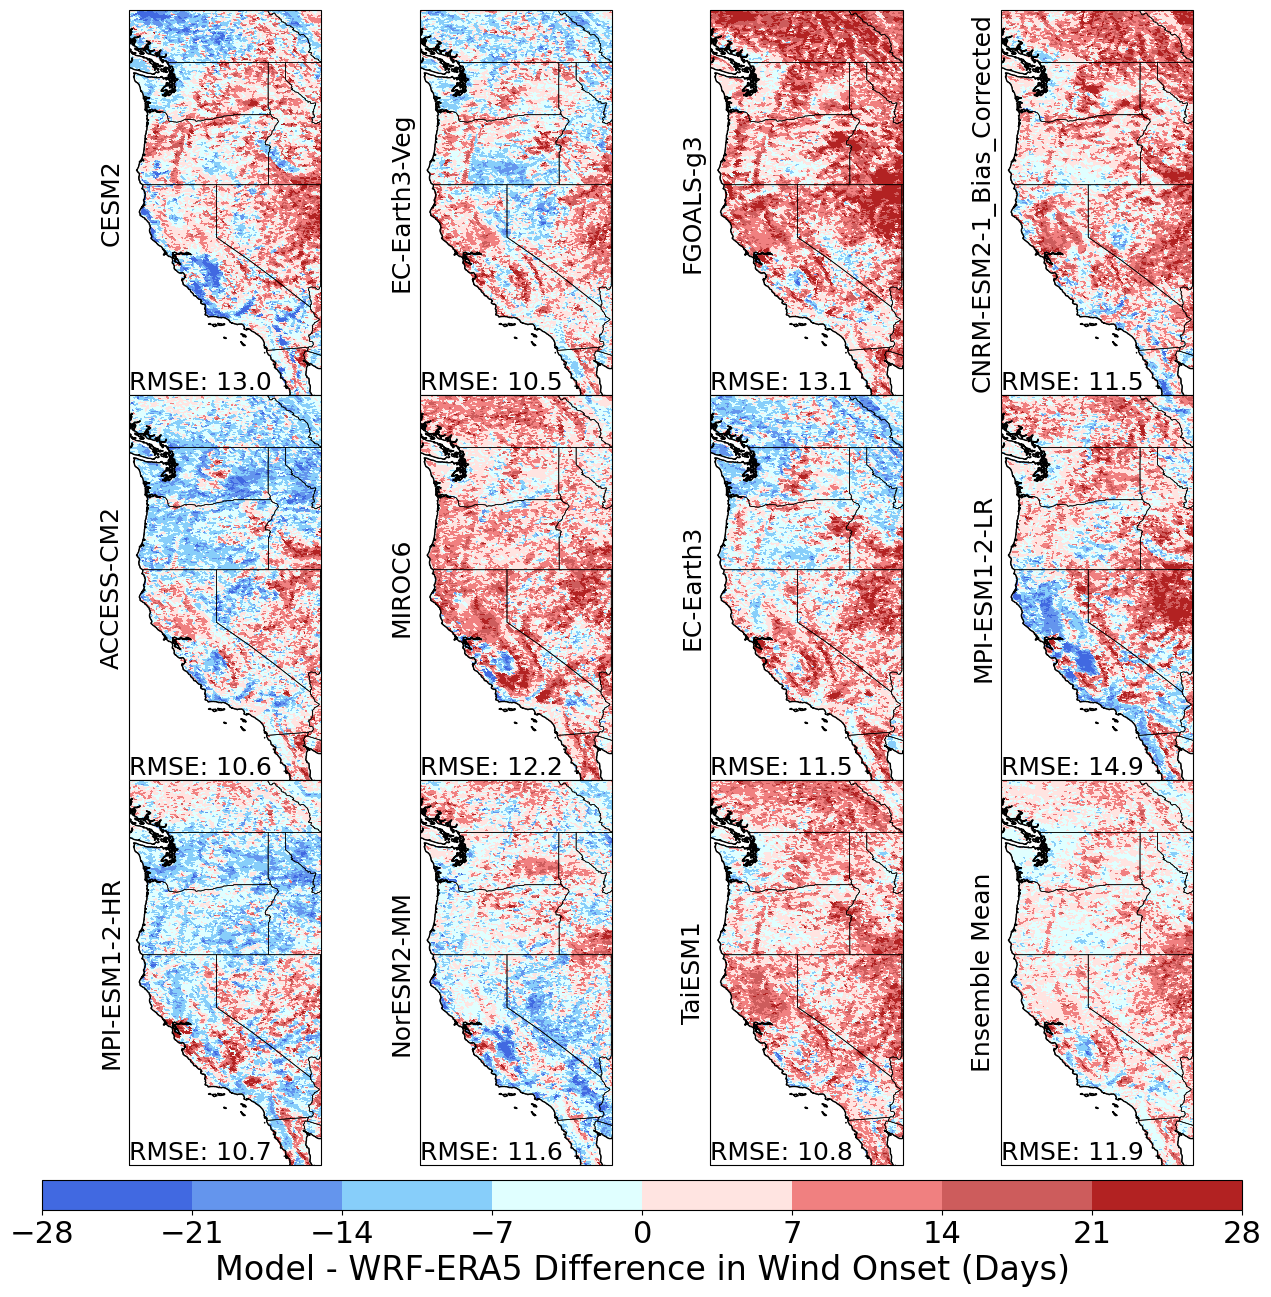

In [9]:
## Plot Wind Bias
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])


latmask = (lat_wrf > 30) & (lat_wrf < 52)
lonmask = (lon_wrf > -125) & (lon_wrf < -114)


fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
all_models = []
all_rmse = []
for model in model_list:
    file = model_directory+'/'+model+'/'+model+'_1981_2010_first_wet_and_wind_nans.nc'
    dataset = xr.open_dataset(file)
    first_wet_hist = dataset.first_wind_hist  
    first_wet_mean = first_wet_hist.mean(dim='newyear')
    
    bias = first_wet_mean -  era5_wind_mean 
    subset_bias = bias.where(latmask & lonmask, drop=True)
    squared_diff = (subset_bias)**2
    mse = squared_diff.mean(dim=('lat2d', 'lon2d'))
    rmse = np.sqrt(mse)
    all_models.append(bias)
    all_rmse.append(rmse)
all_models = xr.concat(all_models,dim='model')
all_rmse = xr.concat(all_rmse,dim='model')
ensemble_mean = all_models.mean(dim='model')
ensemble_mean_rmse = all_rmse.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
all_models_rmse = xr.concat([all_rmse,ensemble_mean_rmse],dim='model')
model_list.append('Ensemble Mean')

for x,model in enumerate(model_list):
    bias = all_models_new[x]
    rmse = all_models_rmse[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],bias,cmap=segment_map3,vmin=-28,vmax=28)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    #ax.set_ylabel(model,fontsize=18)
    label = model+' - '+str(rmse.values.round(decimals=1, out=None))
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-125, 30, f'RMSE: {rmse.values.round(decimals=1)}', fontsize=18, color='black', ha='left', va='bottom')


    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = plt.colorbar(im,ticks=[-28, -21, -14, -7, 0, 7, 14, 21, 28],cax=cbar_ax,orientation='horizontal')
#cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Model - WRF-ERA5 Difference in Wind Onset (Days)',fontsize=24)

plt.show()

## Rain Likelihood Heatmap Bias

In [21]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
model_list.append('Ensemble Mean')

# recalculate era5 heatmap data

era5_likelihood = xr.open_dataset('/era5/entire_domain_rain_only.nc')
era5_likelihood_wind = xr.open_dataset('/era5/entire_domain_wind_all_year.nc')

# Try a heatmap of latitudinal bands
lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]

era5_means = []

for lat_range, lon_range in lat_lon_ranges:
    latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
    lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
    era5_subset = era5_likelihood.where(latmask & lonmask, drop=True)
    era5_mean = era5_subset.mean(dim=['lat2d', 'lon2d'])
    era5_means.append(era5_mean)

# Now era5_means contains all the mean values for each latitude and longitude range
window_size = 1
era5_avg_rains = []  # Create a list to store the averaged rain DataArrays

for era5_mean in era5_means:
    era5_avg_rain = era5_mean.rain
    era5_avg_rain = era5_avg_rain.rolling(day=window_size, center=True).mean()
    era5_avg_rains.append(era5_avg_rain)

heatmap_data = xr.concat(era5_avg_rains,dim='transect')

# replace the index values with latitude values
# Define the latitude ranges from lat_lon_ranges
latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

# Create a new DataArray with updated transect values
new_transect = xr.DataArray(latitudes, dims='transect')

# Update the heatmap_data with the new transect values
heatmap_data['transect'] = new_transect

In [22]:
# load model heatmap data
model_array_hist = xr.open_dataset('/historical_rain_heatmap_data.nc')

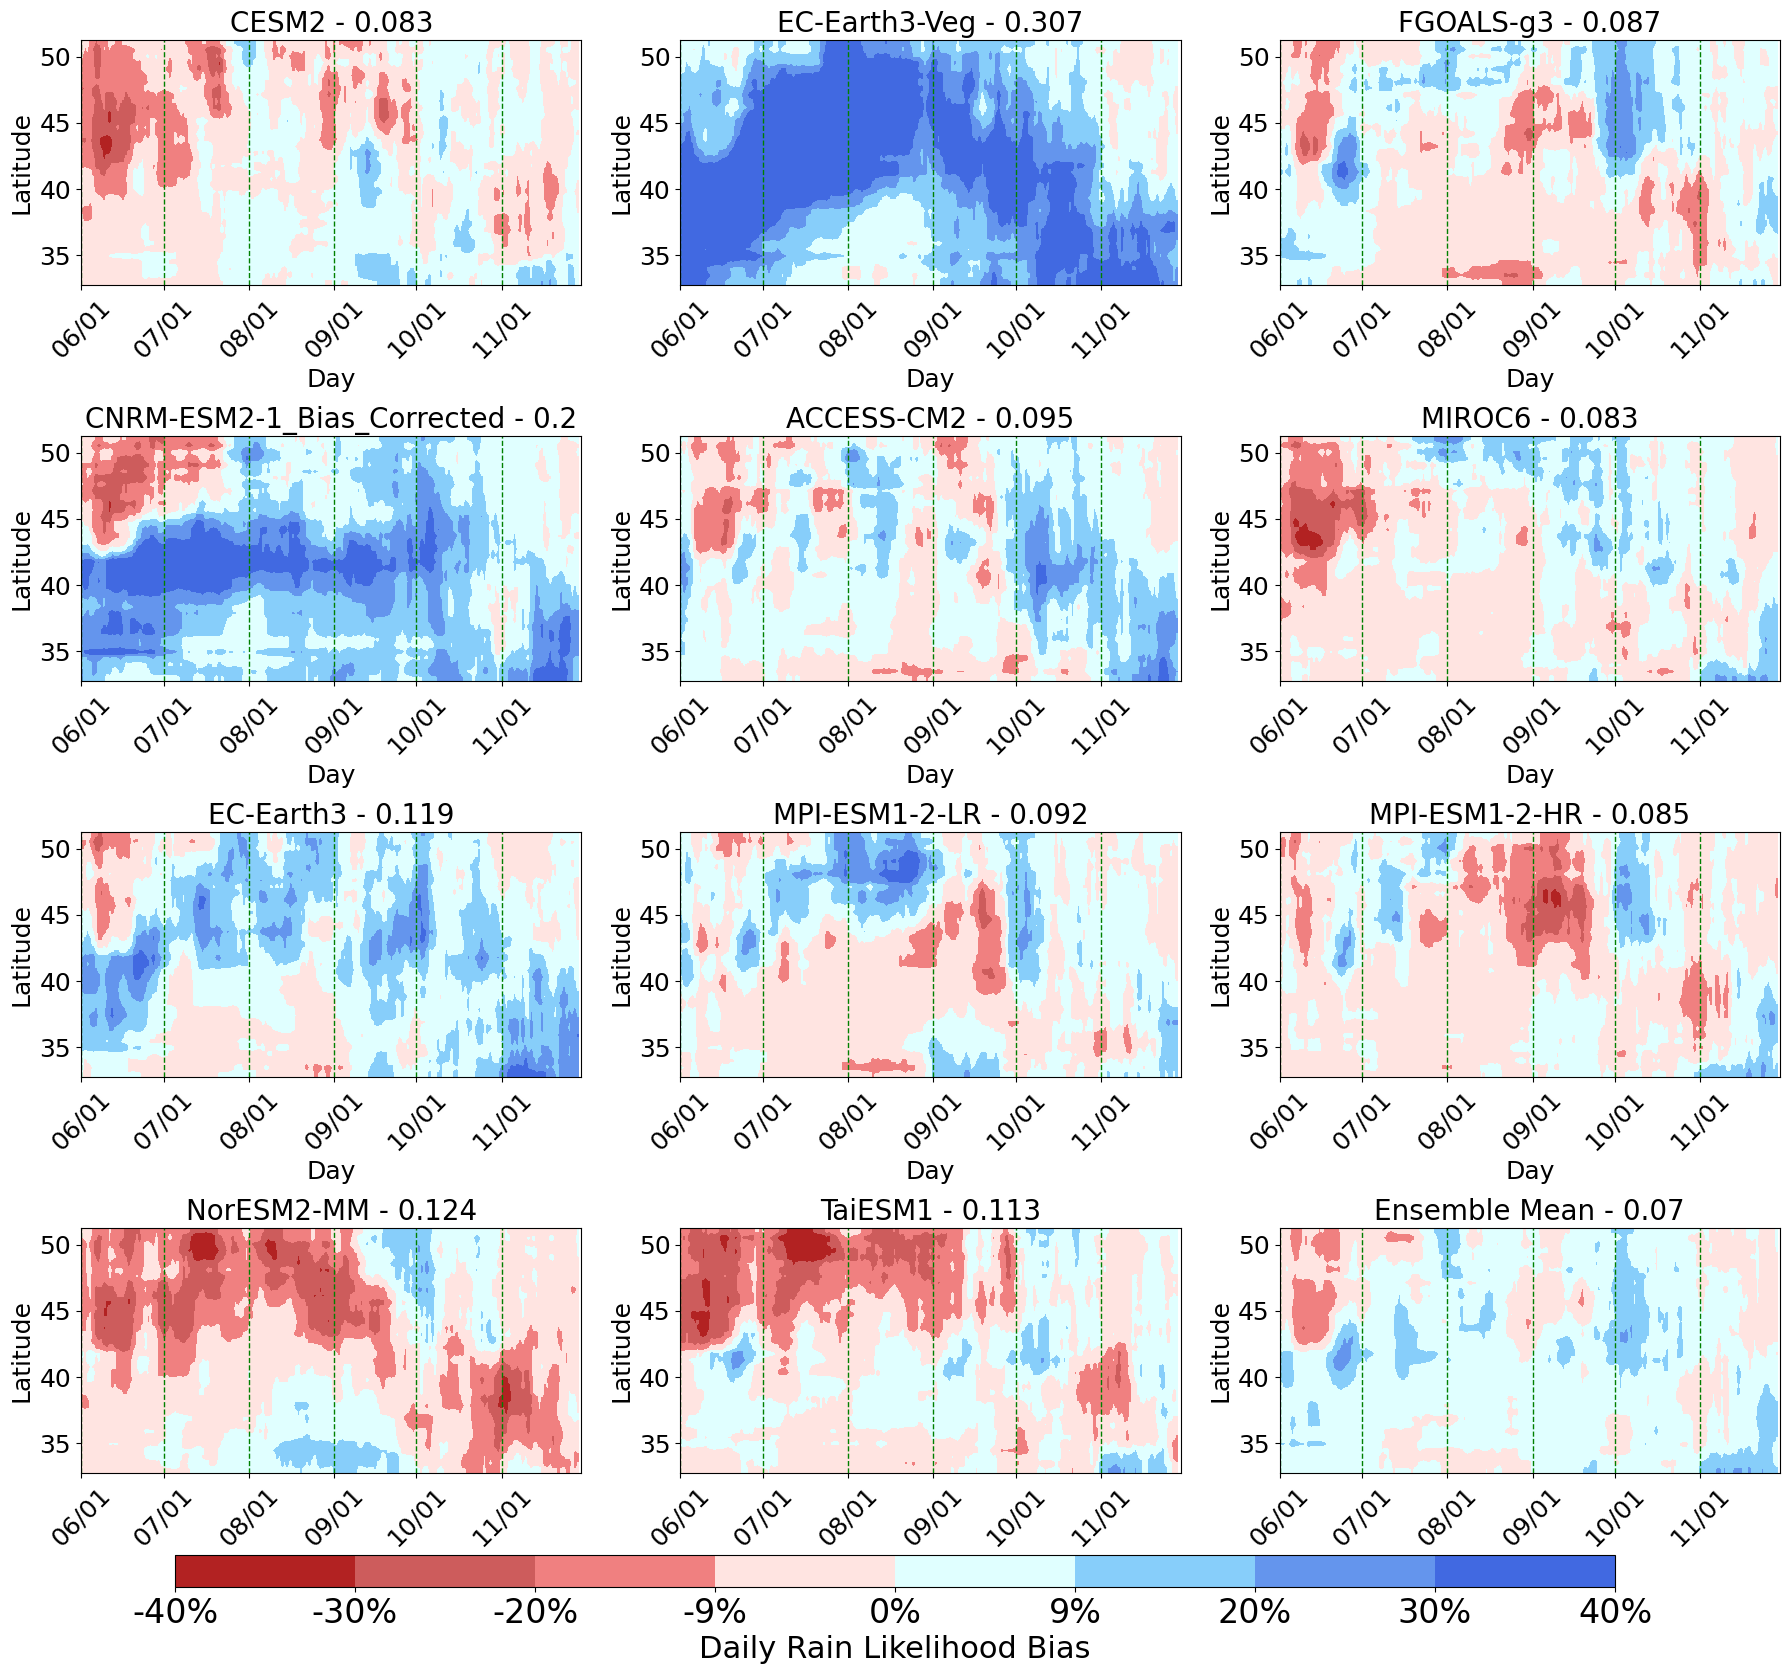

In [23]:
# plotting
model_eval = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])
# Generate the date range from June 1st to November 30th
start_date = datetime.date(2023, 6, 1)
end_date = datetime.date(2023, 12, 30)
delta = datetime.timedelta(days=1)

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += delta
tick_positions = []
tick_labels = []

for i, date in enumerate(dates):
    if date.day == 1:
        tick_positions.append(i)
        tick_labels.append(date.strftime('%m/%d'))
        
bias = model_array_hist - heatmap_data
#model_diff = model_array_fut - model_array

# Assuming you have your xarray dataset with dimensions (model: 10, day: 182, lat2d: N)
# Replace the following line with your actual dataset loading code
# model_array = xr.open_dataset('your_dataset.nc')

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = 3

# Define the size of each subplot
subplot_width = 5  # Adjust as needed
subplot_height = 4  # Adjust as needed

# Create the figure with specified size
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 16))

# Loop through the models (assuming there are 10 models)
for model_index in range(12):
    # Select the data for the current model
    model_selection = bias.sel(model=model_index)

    
    # Extract the numpy arrays from the xarray dataset
    day = model_selection['day'].values
    lat2d = model_selection['transect'].values
    rain = model_selection['rain'].values
    
    squared_diff = (model_selection)**2
    mse = squared_diff.mean(dim=('transect', 'day'))
    rmse = np.sqrt(mse)

    # Calculate the subplot position
    row = model_index // num_cols
    col = model_index % num_cols

    # Create the heatmap for the current model
    im = axs[row, col].imshow(rain, cmap=model_eval.reversed(), extent=[day.min(), day.max(), lat2d.min(), lat2d.max()], aspect='auto',vmin=-.4,vmax=.4)
    axs[row, col].set_title(f'Model {model_index + 1}')  # Set subplot title
    axs[row, col].set_xlabel('Day',fontsize=18)
    axs[row, col].set_ylabel('Lat2d',fontsize=18)
    # Other settings for your subplots (you can keep your existing code here)
    for tick_position in tick_positions:
        axs[row, col].axvline(tick_position, color='green', linestyle='dashed', linewidth=1)
        
    axs[row, col].set_xticks(tick_positions)
    axs[row, col].set_xticklabels(tick_labels, rotation=45)
    axs[row, col].set_xticklabels(tick_labels, rotation=45,fontsize=18)
    label = model_list[model_index]+' - '+str(rmse.rain.values.round(decimals=3, out=None))
    axs[row, col].set_title(label,fontsize=20)
    axs[row, col].set_ylabel('Latitude',fontsize=18)
    axs[row, col].tick_params(axis='y', labelsize=18)
    axs[row, col].set_xlim(0,182)
# Adjust layout and display the subplots
plt.tight_layout()

# Create a colorbar
plt.tight_layout(w_pad=2, h_pad=1)
cax = fig.add_axes([0.1, 0.005, 0.8, 0.02])  # [x, y, width, height] values for the colorbar position
cbar = plt.colorbar(im, cax=cax, label='Wind Likelihood', orientation='horizontal')
new_ticks = np.linspace(-.4, .4, 9)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Daily Rain Likelihood Bias',fontsize='22')
# Adjust layout and display the subplots

plt.show()


## Dry Wind Likelihood

In [27]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/wrfinput_d02_coord.nc')

In [28]:
# load era5

era5_file = model_directory+'/era5/era5_1981_2010_95_total_occurence.nc'
fw_dataset = xr.open_dataset(era5_file)
total_wind = fw_dataset.total_wind.sum(dim='newyear')
dry_wind = fw_dataset.dry_wind_total.sum(dim='newyear')
proportion_era5 = dry_wind/total_wind

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


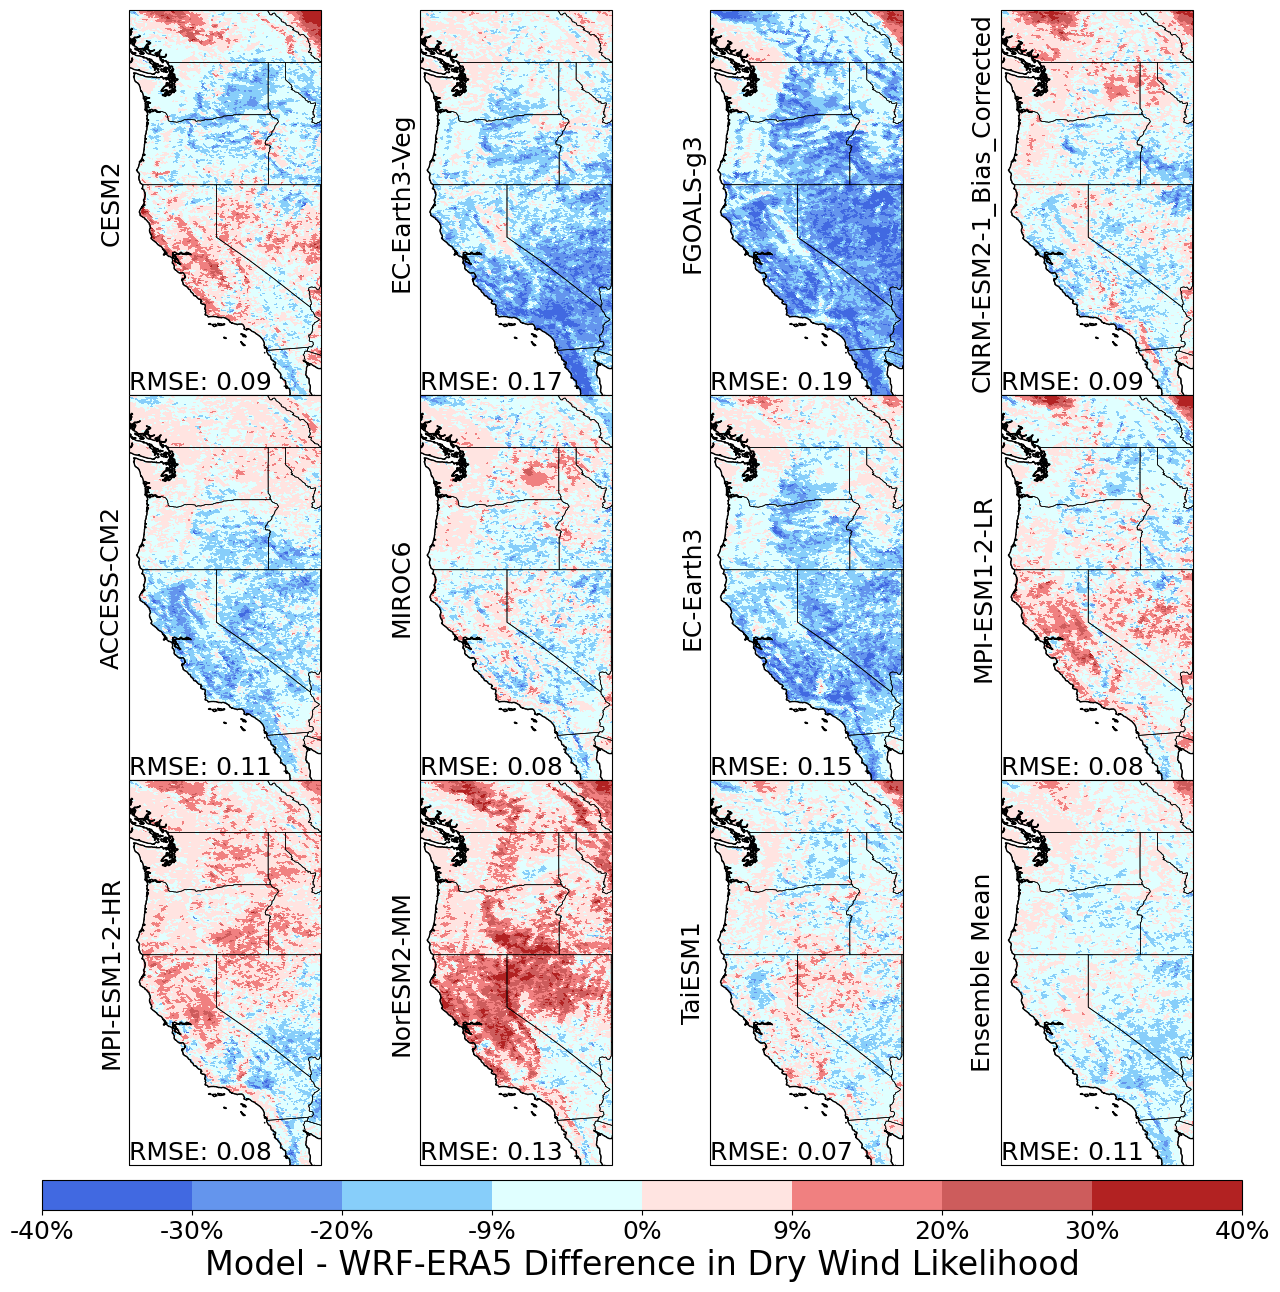

In [29]:
# load models and plot
segment_map3 = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])

lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])


latmask = (lat_wrf > 30) & (lat_wrf < 52)
lonmask = (lon_wrf > -125) & (lon_wrf < -114)


import matplotlib.gridspec as gridspec
fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)

all_models = []
all_rmse = []
all_bias = []
for model in model_list:
    fire_weather_file = model_directory+'/'+model+'/'+model+'_1981_2010_95_total_occurence.nc'
    fw_dataset = xr.open_dataset(fire_weather_file)
    total_wind = fw_dataset.total_wind.sum(dim='newyear')
    dry_wind = fw_dataset.dry_wind_total.sum(dim='newyear')
    proportion = dry_wind/total_wind
    bias = proportion-proportion_era5
    all_bias.append(bias)
    subset_bias = bias.where(latmask & lonmask, drop=True)
    squared_diff = (subset_bias)**2
    mse = squared_diff.mean(dim=('lat2d', 'lon2d'))
    rmse = np.sqrt(mse)
    all_models.append(bias)
    all_rmse.append(rmse)
all_models = xr.concat(all_models,dim='model')
all_rmse = xr.concat(all_rmse,dim='model')
ensemble_mean = all_models.mean(dim='model')
ensemble_mean_rmse = all_rmse.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
all_models_rmse = xr.concat([all_rmse,ensemble_mean_rmse],dim='model')
model_list.append('Ensemble Mean') 

for x,model in enumerate(model_list):
    bias = all_models_new[x]
    rmse = all_models_rmse[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],bias,cmap=segment_map3,vmin=-.4,vmax=.4)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.colorbar()
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    label = model+' - '+str(rmse.values.round(decimals=2, out=None))
    ax.set_ylabel(model,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(-125, 30, f'RMSE: {rmse.values.round(decimals=2)}', fontsize=18, color='black', ha='left', va='bottom')

#plt.colorbar(im,fraction=0.075, pad=0.04)
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
new_ticks = np.linspace(-.4, .4, 9)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]

cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('Model - WRF-ERA5 Difference in Dry Wind Likelihood',fontsize=24)
plt.show()

# Bias in 95th percentile wind speed

In [20]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
era5_95 = xr.open_dataset('/era5/95th_percentile_wind.nc')
era5_95 = era5_95.wspd10mean

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


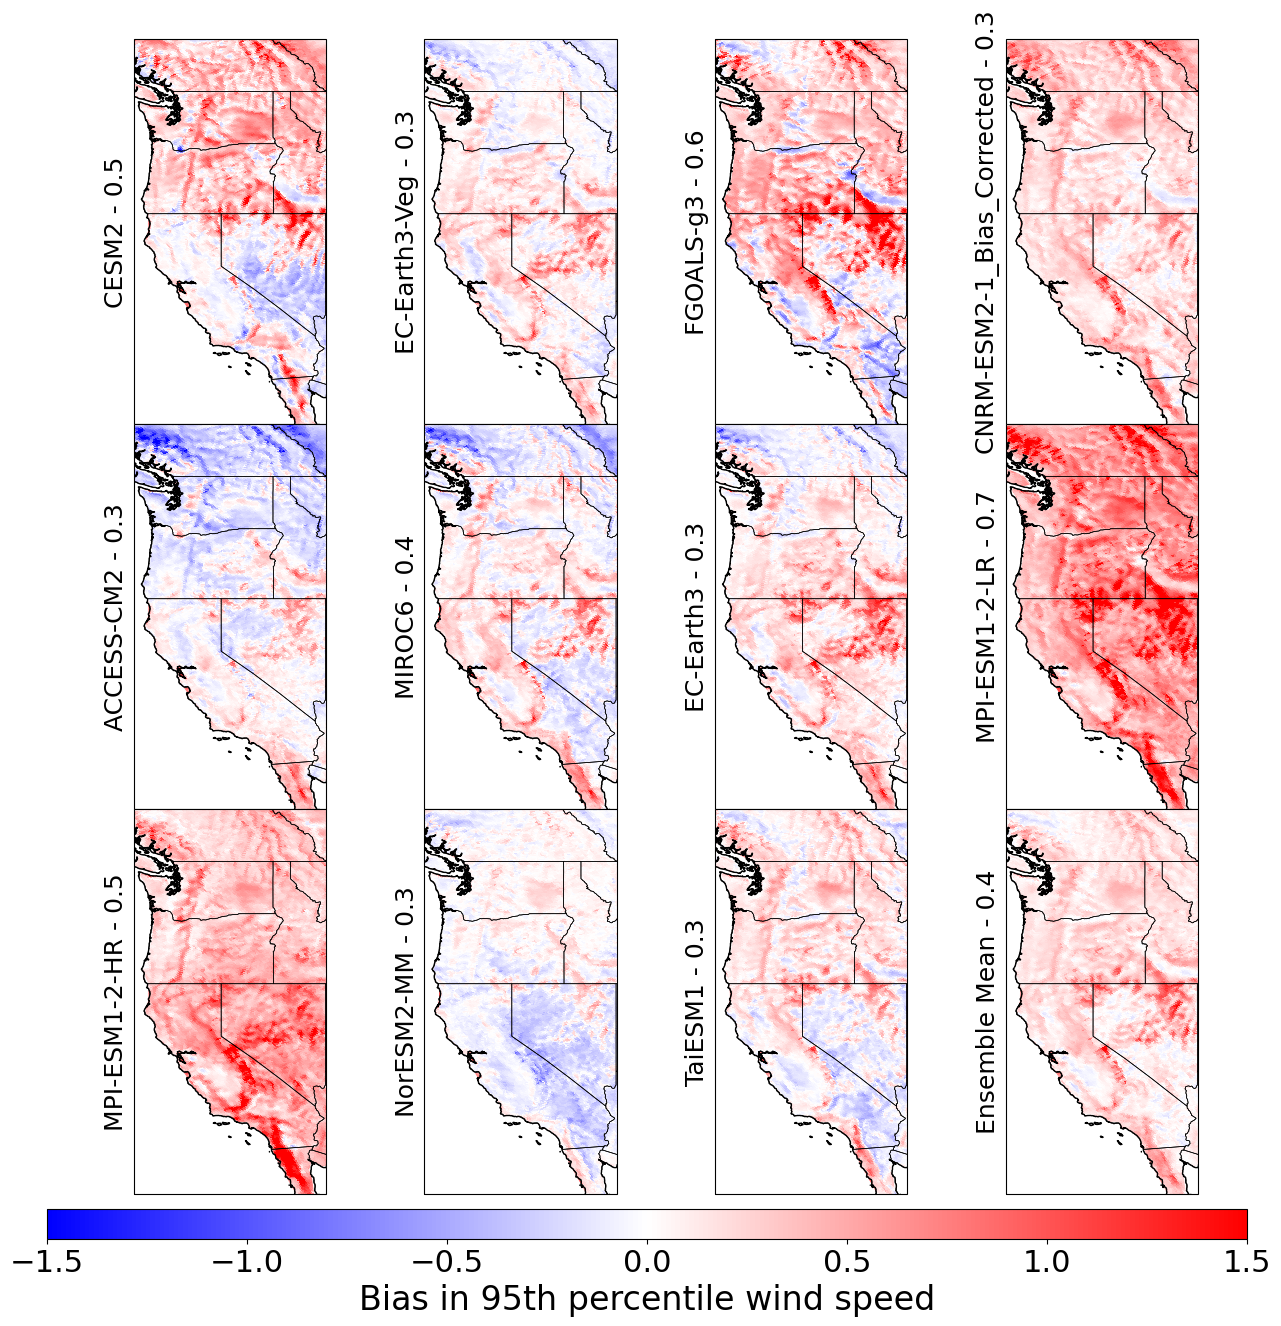

In [21]:
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])


latmask = (lat_wrf > 30) & (lat_wrf < 52)
lonmask = (lon_wrf > -125) & (lon_wrf < -114)


fig,ax = plt.subplots(3,4,figsize=[15,15],constrained_layout=True)
all_models = []
all_rmse = []
for model in model_list:
    file = model_directory+'/'+model+'/95th_percentile_wind.nc'
    dataset = xr.open_dataset(file)
    wspd = dataset.wspd10mean 
    bias = wspd - era5_95
    subset_bias = bias.where(latmask & lonmask, drop=True)
    squared_diff = (bias)**2
    mse = squared_diff.mean(dim=('lat2d', 'lon2d'))
    rmse = np.sqrt(mse)
    all_models.append(bias)
    all_rmse.append(rmse)
all_models = xr.concat(all_models,dim='model')
all_rmse = xr.concat(all_rmse,dim='model')
ensemble_mean = all_models.mean(dim='model')
ensemble_mean_rmse = all_rmse.mean(dim='model')

all_models_new = xr.concat([all_models,ensemble_mean],dim='model')
all_models_rmse = xr.concat([all_rmse,ensemble_mean_rmse],dim='model')
model_list.append('Ensemble Mean')

for x,model in enumerate(model_list):
    bias = all_models_new[x]
    rmse = all_models_rmse[x]
    ax = plt.subplot(3, 4, x+1, projection=ccrs.PlateCarree())
    im = ax.pcolormesh(coords['lon2d'],coords['lat2d'],bias,vmin=-1.5,vmax=1.5,cmap='bwr')
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
    ax.add_feature(ocean)
    #plt.title(model)
    ax.coastlines()
    ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
    ax.set_ylim(30,52)
    ax.set_xlim(-125,-114)
    #ax.set_ylabel(model,fontsize=18)
    label = model+' - '+str(rmse.values.round(decimals=1, out=None))
    ax.set_ylabel(label,fontsize=18)
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='y')
    ax.set_xticks([])
    ax.set_yticks([])

    
fig.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
cbar_ax = fig.add_axes([0.1, 0.08, 0.8, 0.02]) 
cbar = fig.colorbar(im,cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Bias in 95th percentile wind speed',fontsize=24)

plt.show()